In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from neuraldistributions.models import transforms
from neuraldistributions.datasets import static

from multiprocessing import Pool

import os
device = "cuda"

dataport not available, will only be able to load data locally


In [2]:
import numpy as np
import torch

from neuraldistributions.datasets import mouse_static_loaders, extract_data_key
from neuraldistributions.models import poisson, zig, flowfa, ziffa
from neuraldistributions.trainers import base_trainer
from neuraldistributions.utility import get_loglikelihood

In [3]:
random_seed=42
dataset_dir = "../project/data"
datasets = [
    "static_edited_dsampled.zip",
]
scan_id = [2, 1]
dataset_paths = [f"{dataset_dir}/{dataset}" for dataset in datasets]
areas = [["V1", "LM"]]
neurons_ns = [1000, 907]

In [4]:
dataset_index = 0
dataset_path = dataset_paths[dataset_index]
data_key = extract_data_key(dataset_path)
area = areas[dataset_index]
neurons_n = neurons_ns[dataset_index]

dataset_config = {
    "paths": [dataset_path],
    "seed": random_seed,
    "batch_size": 64,
    "area": area,
    "neurons_n": neurons_n,
    "normalize_images": True,
    "normalize_neurons": True,
    "return_more": True,
    "device": device,
    "shuffle_train": True,
}

dataloaders = mouse_static_loaders(**dataset_config)

100%|██████████| 5994/5994 [00:00<00:00, 291246.14it/s]


In [5]:
grid_mean_pred_config = {
    "type": "cortex",
    "input_dimensions": 2,
    "hidden_layers": 4,
    "hidden_features": 20,
    "nonlinearity": "ReLU",
    "final_tanh": True,
}

image_model_config = {
    "pad_input": False,
    "stack": -1,
    "layers": 4,
    "input_kern": 15,
    "gamma_input": 1,
    "gamma_readout": 2.439,
    "hidden_dilation": 1,
    "hidden_kern": 13,
    "hidden_channels": 64,
    "n_se_blocks": 0,
    "depth_separable": True,
    "share_features": False,
    "share_grid": False,
    "init_sigma": 0.4,
    "init_mu_range": 0.55,
    "gauss_type": "full",
    "grid_mean_predictor": grid_mean_pred_config,
}

In [6]:
model_name = "flowfa"
d_latent = 3
sample_transform = "learned-leaky-mixed-k-10"
mean_transform = "learned"
per_neuron_transform = True
unit_variance_constraint = False

model_config = {
    "image_model_fn": "nnsysident.models.models.se2d_fullgaussian2d",
    "image_model_config": image_model_config,
    "d_latent": d_latent,
    "sample_transform": sample_transform,
    "mean_transform": mean_transform,
    "per_neuron_samples_transform": per_neuron_transform,
    "init_psi_diag_coef": 0.1,
    "init_C_coef": 0.1,
    "unit_variance_constraint": unit_variance_constraint,
}
model = flowfa(dataloaders, random_seed, **model_config)

In [7]:
index_name_of_dataloader = next(iter(dataloaders["train"]))
indexes = np.arange(len(dataloaders["image_ids"][index_name_of_dataloader]["test"]))
u, inv = (np.unique(dataloaders["image_ids"][index_name_of_dataloader]["test"], return_inverse=True))
img_indexes = indexes[inv == inv[0]]
print(img_indexes)

[0 1 2 3 4 5 6 7 8 9]


In [8]:
print(model.sample_transform)

Flow(
  (layers): ModuleList(
    (0): Affine(
      init_t=Parameter containing:
      tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0.,

102
435
860
270
106
71
700
20
614


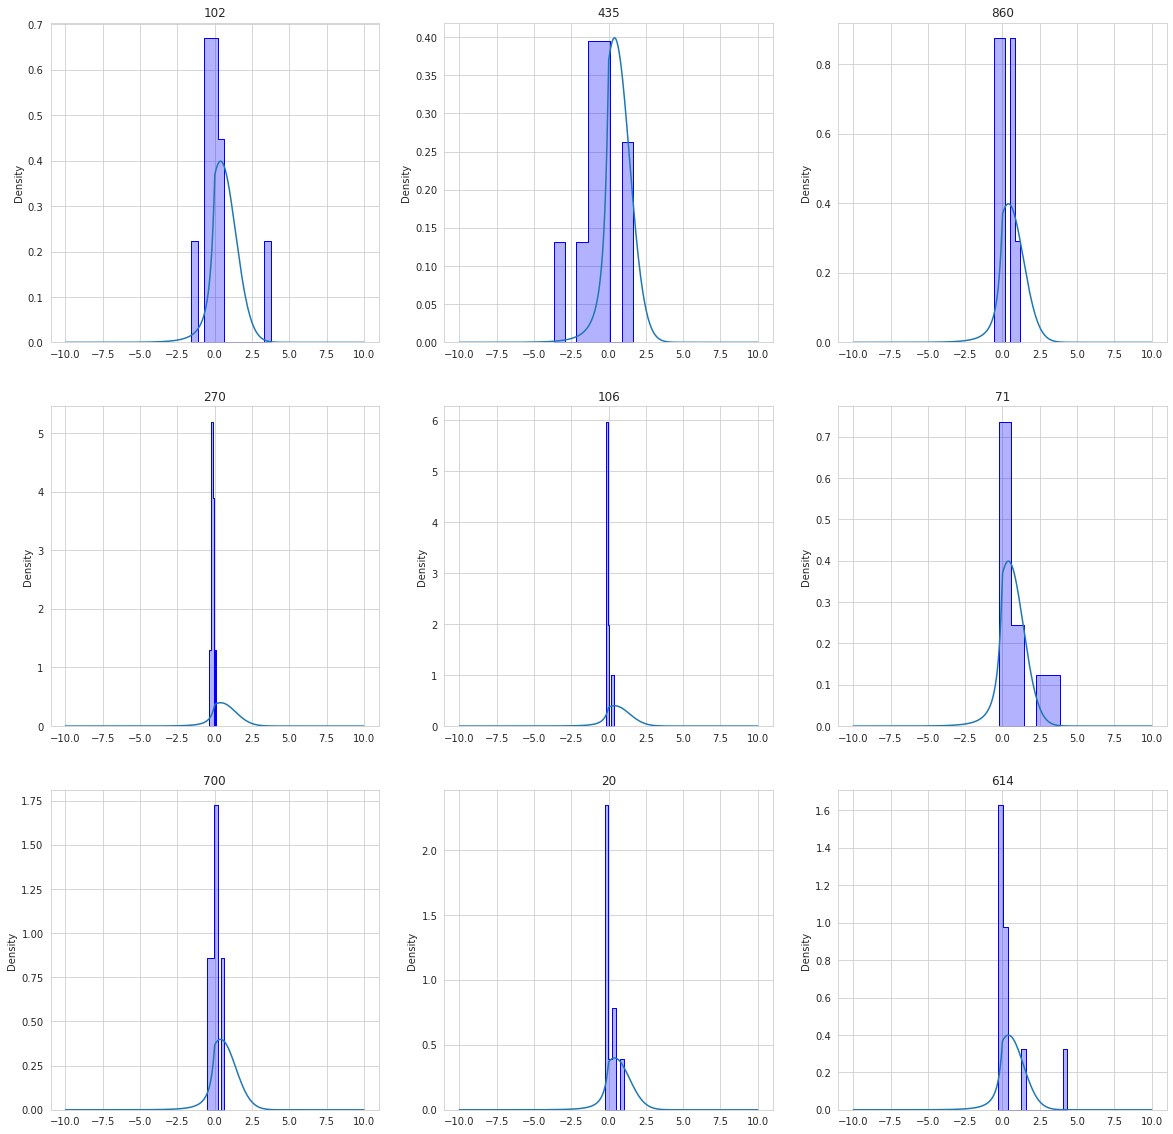

In [9]:
#print distributions before training
batch = (next(iter(dataloaders["test"][index_name_of_dataloader])))
inputs, targets = batch[:2]
mu = model.forward(*batch, data_key=None).to("cpu")
points = torch.linspace(-10,10, 1000).to(device)
test = torch.ones(1000, 1000)
for i in range(1000):
    test[: ,i] = points
transformed_targets, logdet = model.sample_transform(test.to(device))
from matplotlib.pyplot import figure

random_neurons = np.random.choice(1000,9)
normal = torch.distributions.normal.Normal(mu[0][img_indexes[0]], torch.tensor([1.0]))
fig, ax = plt.subplots(3,3, figsize=(20,20))
logdet.detach().to("cpu")
values_before = normal.log_prob(transformed_targets.detach().to("cpu"))
for i, neuron in enumerate(random_neurons):
    print(neuron)
    ax[i//3][i%3].plot(points.detach().cpu(), torch.exp(values_before.detach()[:,neuron] + logdet.detach().to("cpu")[:,neuron]))
    ax[i//3][i%3].set_title(str(neuron))
    sns.histplot(targets[img_indexes][:,neuron].detach().cpu(), ax=ax[i//3][i%3], stat="density", element="step", color="blue", alpha=0.3)
    #ax[i//3][i%3].hist(targets[img_indexes][:,neuron].detach().cpu().numpy(), color="blue", density=True)
plt.show()

In [10]:
trainer_config = {
    "epochs": 500,
    "device": "cuda",
    "lr": 0.005,
    "use_avg_loss": True
}
out = None
## The following line would train the model (upon availability of the dataset)
out = base_trainer(model, dataloaders, random_seed, **trainer_config)

Score improved (nan --> 5712.825195).


100%|██████████| 70/70 [00:03<00:00, 18.20it/s]


Epoch 1/500 | train loss: 4334.406738 | val loss: 2616.211670
Score improved (5712.825195 --> 2616.211670).


100%|██████████| 70/70 [00:03<00:00, 18.30it/s]


Epoch 2/500 | train loss: 2381.297363 | val loss: 1827.681519
Score improved (2616.211670 --> 1827.681519).


100%|██████████| 70/70 [00:03<00:00, 18.27it/s]


Epoch 3/500 | train loss: 1596.201538 | val loss: 1609.232422
Score improved (1827.681519 --> 1609.232422).


100%|██████████| 70/70 [00:03<00:00, 18.28it/s]


Epoch 4/500 | train loss: 1692.557617 | val loss: 1545.122559
Score improved (1609.232422 --> 1545.122559).


100%|██████████| 70/70 [00:03<00:00, 18.28it/s]


Epoch 5/500 | train loss: 1591.978638 | val loss: 1526.209473
Score improved (1545.122559 --> 1526.209473).


100%|██████████| 70/70 [00:03<00:00, 18.28it/s]


Epoch 6/500 | train loss: 1465.677979 | val loss: 1519.123291
Score improved (1526.209473 --> 1519.123291).


100%|██████████| 70/70 [00:03<00:00, 18.22it/s]


Epoch 7/500 | train loss: 1543.874146 | val loss: 1516.027954
Score improved (1519.123291 --> 1516.027954).


100%|██████████| 70/70 [00:03<00:00, 18.25it/s]


Epoch 8/500 | train loss: 1478.834351 | val loss: 1515.232178
Score improved (1516.027954 --> 1515.232178).


100%|██████████| 70/70 [00:03<00:00, 18.32it/s]


Epoch 9/500 | train loss: 1495.130127 | val loss: 1513.851318
Score improved (1515.232178 --> 1513.851318).


100%|██████████| 70/70 [00:03<00:00, 18.31it/s]


Epoch 10/500 | train loss: 1548.002075 | val loss: 1515.135132
EarlyStopping counter: 1 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.31it/s]


Epoch 11/500 | train loss: 1582.773560 | val loss: 1513.084717
Score improved (1513.851318 --> 1513.084717).


100%|██████████| 70/70 [00:03<00:00, 18.32it/s]


Epoch 12/500 | train loss: 1468.323120 | val loss: 1513.216797
EarlyStopping counter: 1 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.32it/s]


Epoch 13/500 | train loss: 1534.251465 | val loss: 1512.905762
Score improved (1513.084717 --> 1512.905762).


100%|██████████| 70/70 [00:03<00:00, 18.34it/s]


Epoch 14/500 | train loss: 1522.584473 | val loss: 1515.630127
EarlyStopping counter: 1 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.33it/s]


Epoch 15/500 | train loss: 1601.516357 | val loss: 1513.964600
EarlyStopping counter: 2 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.32it/s]


Epoch 16/500 | train loss: 1465.806763 | val loss: 1513.866943
EarlyStopping counter: 3 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.34it/s]


Epoch 17/500 | train loss: 1624.502808 | val loss: 1509.793945
Score improved (1512.905762 --> 1509.793945).


100%|██████████| 70/70 [00:03<00:00, 18.33it/s]


Epoch 18/500 | train loss: 1506.364014 | val loss: 1512.497925
EarlyStopping counter: 1 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.33it/s]


Epoch 19/500 | train loss: 1522.669434 | val loss: 1511.957642
EarlyStopping counter: 2 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.33it/s]


Epoch 20/500 | train loss: 1498.775269 | val loss: 1511.779297
EarlyStopping counter: 3 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.43it/s]


Epoch 21/500 | train loss: 1446.147705 | val loss: 1511.741211
EarlyStopping counter: 4 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.51it/s]


Epoch 22/500 | train loss: 1523.012207 | val loss: 1513.835693
EarlyStopping counter: 5 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.44it/s]


Epoch 23/500 | train loss: 1472.285645 | val loss: 1512.077148
EarlyStopping counter: 6 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.41it/s]


Epoch 24/500 | train loss: 1511.052246 | val loss: 1514.887451
EarlyStopping counter: 7 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.45it/s]


Epoch 25/500 | train loss: 1452.242310 | val loss: 1516.466919
EarlyStopping counter: 8 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.44it/s]


Epoch 26/500 | train loss: 1475.919067 | val loss: 1514.424927
EarlyStopping counter: 9 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.44it/s]


Epoch 27/500 | train loss: 1448.467163 | val loss: 1513.122559
EarlyStopping counter: 10 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.44it/s]


Epoch 28/500 | train loss: 1452.155396 | val loss: 1515.925781
EarlyStopping counter: 11 out of 20
Epoch    28: reducing learning rate of group 0 to 1.5000e-03.
Retrieve best model..
Applying changes..


100%|██████████| 70/70 [00:03<00:00, 17.96it/s]


Epoch 29/500 | train loss: 1588.315674 | val loss: 1496.216431
Score improved (1509.793945 --> 1496.216431).
Retrieve best model..


100%|██████████| 70/70 [00:03<00:00, 17.96it/s]


Epoch 30/500 | train loss: 1471.789185 | val loss: 1497.103516
EarlyStopping counter: 1 out of 20


100%|██████████| 70/70 [00:03<00:00, 17.97it/s]


Epoch 31/500 | train loss: 1473.758545 | val loss: 1495.754639
Score improved (1496.216431 --> 1495.754639).


100%|██████████| 70/70 [00:03<00:00, 17.96it/s]


Epoch 32/500 | train loss: 1453.576904 | val loss: 1499.719482
EarlyStopping counter: 1 out of 20


100%|██████████| 70/70 [00:03<00:00, 17.95it/s]


Epoch 33/500 | train loss: 1415.958008 | val loss: 1498.097656
EarlyStopping counter: 2 out of 20


100%|██████████| 70/70 [00:03<00:00, 17.97it/s]


Epoch 34/500 | train loss: 1404.795044 | val loss: 1499.567017
EarlyStopping counter: 3 out of 20


100%|██████████| 70/70 [00:03<00:00, 17.95it/s]


Epoch 35/500 | train loss: 1512.367676 | val loss: 1502.127686
EarlyStopping counter: 4 out of 20


100%|██████████| 70/70 [00:03<00:00, 17.95it/s]


Epoch 36/500 | train loss: 1452.922241 | val loss: 1495.197754
Score improved (1495.754639 --> 1495.197754).


100%|██████████| 70/70 [00:03<00:00, 17.97it/s]


Epoch 37/500 | train loss: 1481.842407 | val loss: 1495.263794
EarlyStopping counter: 1 out of 20


100%|██████████| 70/70 [00:03<00:00, 17.95it/s]


Epoch 38/500 | train loss: 1570.561279 | val loss: 1496.013062
EarlyStopping counter: 2 out of 20


100%|██████████| 70/70 [00:03<00:00, 17.96it/s]


Epoch 39/500 | train loss: 1467.479736 | val loss: 1495.216064
EarlyStopping counter: 3 out of 20


100%|██████████| 70/70 [00:03<00:00, 17.96it/s]


Epoch 40/500 | train loss: 1514.534058 | val loss: 1500.403809
EarlyStopping counter: 4 out of 20


100%|██████████| 70/70 [00:03<00:00, 17.96it/s]


Epoch 41/500 | train loss: 1527.433228 | val loss: 1497.556396
EarlyStopping counter: 5 out of 20


100%|██████████| 70/70 [00:03<00:00, 17.95it/s]


Epoch 42/500 | train loss: 1483.213501 | val loss: 1499.899658
EarlyStopping counter: 6 out of 20


100%|██████████| 70/70 [00:03<00:00, 17.95it/s]


Epoch 43/500 | train loss: 1438.869751 | val loss: 1495.662109
EarlyStopping counter: 7 out of 20


100%|██████████| 70/70 [00:03<00:00, 17.94it/s]


Epoch 44/500 | train loss: 1506.579956 | val loss: 1498.632202
EarlyStopping counter: 8 out of 20


100%|██████████| 70/70 [00:03<00:00, 17.95it/s]


Epoch 45/500 | train loss: 1484.102295 | val loss: 1496.745605
EarlyStopping counter: 9 out of 20


100%|██████████| 70/70 [00:03<00:00, 17.96it/s]


Epoch 46/500 | train loss: 1438.659424 | val loss: 1502.982910
EarlyStopping counter: 10 out of 20


100%|██████████| 70/70 [00:03<00:00, 17.95it/s]


Epoch 47/500 | train loss: 1431.354736 | val loss: 1497.326904
EarlyStopping counter: 11 out of 20
Epoch    47: reducing learning rate of group 0 to 1.5000e-03.
Retrieve best model..


100%|██████████| 70/70 [00:03<00:00, 17.95it/s]


Epoch 48/500 | train loss: 1497.407593 | val loss: 1494.782227
Score improved (1495.197754 --> 1494.782227).


100%|██████████| 70/70 [00:03<00:00, 17.95it/s]


Epoch 49/500 | train loss: 1464.401001 | val loss: 1495.655273
EarlyStopping counter: 1 out of 20


100%|██████████| 70/70 [00:03<00:00, 17.95it/s]


Epoch 50/500 | train loss: 1426.637451 | val loss: 1496.236694
EarlyStopping counter: 2 out of 20


100%|██████████| 70/70 [00:03<00:00, 17.96it/s]


Epoch 51/500 | train loss: 1476.326172 | val loss: 1495.030762
EarlyStopping counter: 3 out of 20


100%|██████████| 70/70 [00:03<00:00, 17.96it/s]


Epoch 52/500 | train loss: 1425.796753 | val loss: 1496.602051
EarlyStopping counter: 4 out of 20


100%|██████████| 70/70 [00:03<00:00, 17.93it/s]


Epoch 53/500 | train loss: 1420.215820 | val loss: 1495.995361
EarlyStopping counter: 5 out of 20


100%|██████████| 70/70 [00:03<00:00, 17.96it/s]


Epoch 54/500 | train loss: 1413.699341 | val loss: 1496.689453
EarlyStopping counter: 6 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.02it/s]


Epoch 55/500 | train loss: 1424.035034 | val loss: 1496.007812
EarlyStopping counter: 7 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.03it/s]


Epoch 56/500 | train loss: 1506.249634 | val loss: 1497.209961
EarlyStopping counter: 8 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.02it/s]


Epoch 57/500 | train loss: 1446.493042 | val loss: 1495.572632
EarlyStopping counter: 9 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.02it/s]


Epoch 58/500 | train loss: 1422.202148 | val loss: 1496.139893
EarlyStopping counter: 10 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.01it/s]


Epoch 59/500 | train loss: 1342.945679 | val loss: 1495.735962
EarlyStopping counter: 11 out of 20
Epoch    59: reducing learning rate of group 0 to 4.5000e-04.
Retrieve best model..


100%|██████████| 70/70 [00:03<00:00, 18.01it/s]


Epoch 60/500 | train loss: 1401.354126 | val loss: 1494.918213
EarlyStopping counter: 12 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.01it/s]


Epoch 61/500 | train loss: 1552.863403 | val loss: 1495.424316
EarlyStopping counter: 13 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.01it/s]


Epoch 62/500 | train loss: 1451.061768 | val loss: 1495.293213
EarlyStopping counter: 14 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.02it/s]


Epoch 63/500 | train loss: 1431.560669 | val loss: 1495.454468
EarlyStopping counter: 15 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.01it/s]


Epoch 64/500 | train loss: 1497.408447 | val loss: 1495.887451
EarlyStopping counter: 16 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.02it/s]


Epoch 65/500 | train loss: 1528.814941 | val loss: 1495.585449
EarlyStopping counter: 17 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.02it/s]


Epoch 66/500 | train loss: 1364.037109 | val loss: 1495.923706
EarlyStopping counter: 18 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.01it/s]


Epoch 67/500 | train loss: 1373.989624 | val loss: 1496.267578
EarlyStopping counter: 19 out of 20


100%|██████████| 70/70 [00:03<00:00, 18.02it/s]


Epoch 68/500 | train loss: 1334.268188 | val loss: 1495.746460
EarlyStopping counter: 20 out of 20
Early stopping at epoch 67. Best val loss: 1494.782
Retrieve best model..


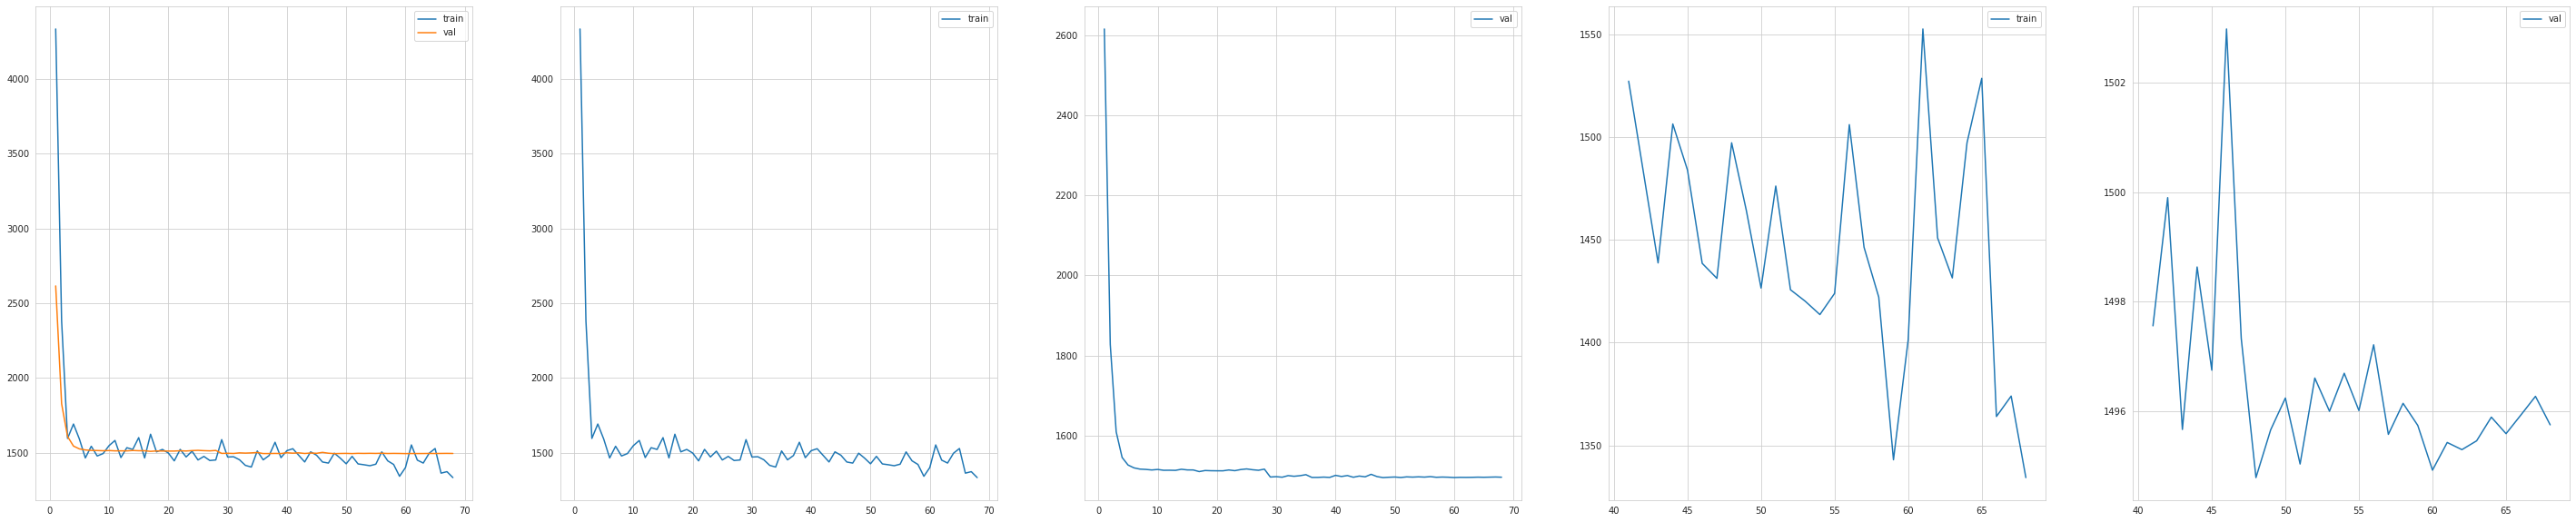

In [11]:
if out is not None:
    fig, ax = plt.subplots(1,5,figsize=(50,10))
    ax[0].plot((np.arange(len(out[1][0]))+1), out[1][0], label="train")
    ax[0].plot((np.arange(len(out[1][0]))+1), out[1][1], label="val")
    ax[1].plot((np.arange(len(out[1][0]))+1), out[1][0], label="train")
    ax[2].plot((np.arange(len(out[1][0]))+1), out[1][1], label="val")
    ax[3].plot((np.arange(len(out[1][0]))+1)[40:], out[1][0][40:], label="train")
    ax[4].plot((np.arange(len(out[1][0]))+1)[40:], out[1][1][40:], label="val")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()
    ax[4].legend()
    plt.show()

In [12]:
#model.load_state_dict(torch.load("edited_data_only_ident"))
#model.eval()

In [13]:
#torch.save(model.state_dict(), "edited_data_only_ident")

In [14]:
print(model)

FlowFA(
  (encoding_model): Encoder(
    (core): SE2dCore(
      (_input_weights_regularizer): LaplaceL2norm(
        (laplace): Laplace()
      )
      (features): Sequential(
        (layer0): Sequential(
          (conv): Conv2d(1, 64, kernel_size=(15, 15), stride=(1, 1), bias=False)
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
          (nonlin): ELU(alpha=1.0, inplace=True)
        )
        (layer1): Sequential(
          (ds_conv): DepthSeparableConv2d(
            (in_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (spatial_conv): Conv2d(64, 64, kernel_size=(13, 13), stride=(1, 1), padding=(6, 6), groups=64, bias=False)
            (out_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
          (nonlin): ELU(alpha=1.0, inplace=True)
        )
        (la

In [15]:
from utility_extended import *

In [16]:
print(f"Train loss: {calcLossForDataset(model, dataloaders['train'], 1000, True)}\nVal loss: {calcLossForDataset(model, dataloaders['validation'], 1000, True)}\nTest loss: {calcLossForDataset(model, dataloaders['test'], 1000, True)}")

Train loss: 2.010699071787083
Val loss: 1.9560167398404593
Test loss: 1.9576972192267172
